In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [6]:
def ends_filler(columns):
    if  pd.api.types.is_numeric_dtype(columns):
        columns = first_filler(columns)
        columns = last_filler(columns)
    return columns

def first_filler(column):
    if pd.isnull(column.at[0]) or np.isnan(column.at[0]):
        size = len(column) -1
        first_valid_index = 0
        while first_valid_index <= size and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > size:
            column.at[0] = 0.0
        else:
            column.at[0] = column.at[first_valid_index]
    return column
    
def last_filler(column):
    if pd.isnull(column.at[len(column) -1]) or np.isnan(column.at[len(column) -1]):
        last_valid_index = len(column) -1
        while last_valid_index >= 0 and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < 0:
            column.at[len(column) -1] = 0.0
        else:
            column.at[len(column) -1] = column.at[last_valid_index]
    return column
    
def neareast_four_indexes(column, start, end):
    index_list = [0] * 8
    index_list[3] = start
    index_list[4] = end
    for i in range(1,4):
        index_list[3 - i] = prev_valid_index(column, start - i + 1)
        index_list[4 + i] = next_valid_index(column, end + i -1)
    return index_list

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, len(nearest_indexes) - 1)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    for i in range(4):
        column = ends_filler(column)
    size = len(column) -1
    nearest_values = []
    if column.isnull().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes)

    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Polynomial Plot')

    plt.show()

                   

In [7]:

pd.set_option('display.max_columns', None)
original_data = {
    'Date': ['2022/01/01', '2022/01/01', '2022/01/01', '2022/01/01', '2022/01/01',
            '2022/01/01', '2022/01/01', '2022/01/01', '2022/01/01', '2022/01/01',
            '2022/01/01'],
    'Atmospheric Pressure (mB)': [920.5, 920.8, 920.8, 920.4, 919.7, 919.0, 919.0, 919.2, 919.7, 920.3, 921.2],
    'Global Radiation - Daylight (Kj/m²)': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.8, 420.6],
    'Air Temperature - Dry Bulb (°C)': [19.3, 19.1, 19.0, 18.7, 18.5, 18.3, 18.1, 18.2, 18.3, 18.5, 19.3],
    'Air Relative Humidity (%)': [92.0, 93.0, 93.0, 93.0, 93.0, 93.0, 94.0, 94.0, 94.0, 95.0, 93.0],
    'Wind Gust (m/s)': [0.7, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3]
}

data = {
    'Date': ['2022/01/01', '2022/01/01', '2022/01/01', '2022/01/01', '2022/01/01',
            '2022/01/01', '2022/01/01', '2022/01/01', '2022/01/01', '2022/01/01',
            '2022/01/01'],
    'Atmospheric Pressure (mB)': [920.5, 920.8, 920.8, 920.4, np.nan, 919.0, 919.0, 919.2, 919.7, 920.3, 921.2]
    ,'Global Radiation - Daylight (Kj/m²)': [np.nan, np.nan, np.nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.8, 420.6],
    'Air Temperature - Dry Bulb (°C)': [19.3, 19.1, 19.0, 18.7, np.nan, np.nan, np.nan, 18.2, 18.3, 18.5, 19.3],
    'Air Relative Humidity (%)': [np.nan, np.nan, 93.0, 93.0, 93.0, 93.0, 94.0, 94.0, np.nan, np.nan, np.nan],
    'Wind Gust (m/s)': [0.7, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3]
}

df = pd.DataFrame(data)
df

,Date,Atmospheric Pressure (mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Air Relative Humidity (%),Wind Gust (m/s)
0,2022/01/01,920.5,NaN,19.3,NaN,0.7
1,2022/01/01,920.8,NaN,19.1,NaN,0.1
2,2022/01/01,920.8,NaN,19.0,93.0,0.0
3,2022/01/01,920.4,0.0,18.7,93.0,0.0
4,2022/01/01,NaN,0.0,NaN,93.0,0.0
5,2022/01/01,919.0,0.0,NaN,93.0,0.0
6,2022/01/01,919.0,0.0,NaN,94.0,0.0
7,2022/01/01,919.2,0.0,18.2,94.0,0.0
8,2022/01/01,919.7,0.0,18.3,NaN,0.0
9,2022/01/01,920.3,49.8,18.5,NaN,0.3


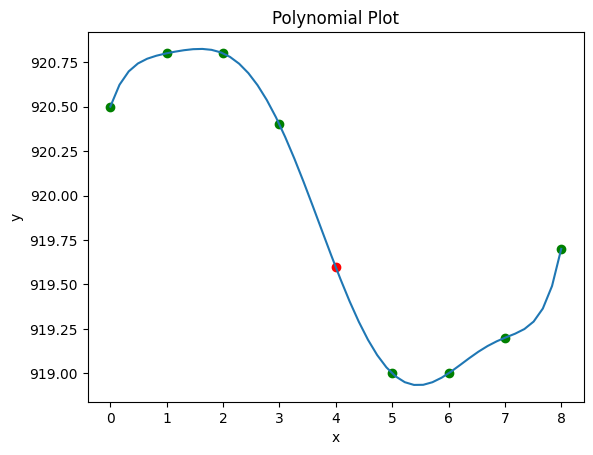

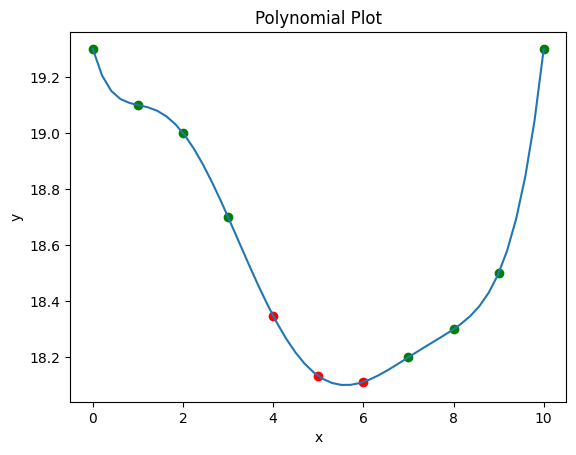

,Date,Atmospheric Pressure (mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Air Relative Humidity (%),Wind Gust (m/s)
0,2022/01/01,920.500000,0.0,19.300000,93.0,0.7
1,2022/01/01,920.800000,NaN,19.100000,NaN,0.1
2,2022/01/01,920.800000,NaN,19.000000,93.0,0.0
3,2022/01/01,920.400000,0.0,18.700000,93.0,0.0
4,2022/01/01,919.597143,0.0,18.347619,93.0,0.0
5,2022/01/01,919.000000,0.0,18.133333,93.0,0.0
6,2022/01/01,919.000000,0.0,18.111905,94.0,0.0
7,2022/01/01,919.200000,0.0,18.200000,94.0,0.0
8,2022/01/01,919.700000,0.0,18.300000,NaN,0.0
9,2022/01/01,920.300000,49.8,18.500000,NaN,0.3


In [8]:
for column in df.columns:
    df[column] = polynomial_filler(df[column])
df